# Step 0. 필수 라이브러리 불러오기 및 실험용 데이터 불러오기

각 과정에 대한 설명은 Readme 참고

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml # MNIST dataset

from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances

In [16]:
MNIST = fetch_openml('mnist_784').data
MNIST_label = fetch_openml('mnist_784').target

In [27]:
data=MNIST[::1000]
label=MNIST_label[::1000]

# Step 1. 각 데이터 포인트의 이웃을 할당한다.
LLE의 첫번째 step은 앞선 Readme에서 설명한 바와 같이 각 데이터 포인트에 이웃을 할당하는 것이다.  
가장 먼저 이웃 할당 여부를 결정하기 위한 distance-metric을 결정하고 e-neighbourhood, K-nearest neighbors, locality sensitive hashing 등의 방법론 들을 통해 이웃을 할당한다.  

본 실습에서는 우선 euclidean_distances를 사용하여 K-nearest neighbors를 구하고 마지막에 manhattan_distances를 사용한 결과와 비교하고자한다.

In [28]:
# 데이터 X에 대해 distance metric을 기준으로 K-nearest neighbors 산출, dist는 해당 거리
def get_neighbors(data, k, distance='euclidean'): 
    if distance == 'euclidean':
        dist = euclidean_distances(data)
    elif distance == 'manhattan':
        dist = manhattan_distances(data)
    
    indices= dist.argsort(axis=1)
    # dist = np.sort(dist, axis=1)
    # dist = dist[:, 1:k+1]
    indices = indices[:, 1:k+1]
    return indices#, dist

In [29]:
k_euclidean=get_neighbors(data, 5, distance='euclidean')
k_euclidean

array([[33, 45, 10, 25, 52],
       [ 6, 38, 27, 44,  3],
       [59, 48,  1, 27,  3],
       [ 1, 18,  2, 44, 47],
       [40, 12, 61, 25, 69],
       [23, 18, 37, 66, 39],
       [62, 11, 59, 63, 31],
       [45, 56, 22, 46, 50],
       [47, 44,  1,  3, 31],
       [57, 37,  8, 19, 58],
       [45, 33, 30, 22, 65],
       [59,  6, 62, 52, 63],
       [60,  4, 58, 38, 69],
       [60, 26, 48, 14, 21],
       [35, 28, 42, 22, 67],
       [54, 27, 65, 63, 33],
       [19, 24, 32, 38, 36],
       [30, 65, 50, 10, 22],
       [34, 66, 39, 48,  3],
       [16, 24,  4, 32, 50],
       [31, 27, 15, 44, 47],
       [14, 46, 26, 25, 13],
       [14, 35, 42, 30, 56],
       [51,  5, 66, 60, 18],
       [19, 32, 16, 38, 50],
       [61, 14, 28, 21, 26],
       [48, 13, 62, 21, 46],
       [15, 20,  1, 30, 31],
       [35, 14, 42, 67, 56],
       [26, 67, 55, 56, 42],
       [22, 65, 10, 67, 14],
       [20,  6, 27,  1, 15],
       [24, 38, 16, 62, 50],
       [45, 10, 22, 65,  0],
       [18, 46

In [30]:
#manhattan 거리 기준 이웃
k_manhattan=get_neighbors(data, 5, distance='manhattan')

# Step 2. 할당된 이웃들을 활용하여 중심의 데이터를 표현하기 위한 최적의 가중치를 찾는다.

In [31]:
def get_W(data, neighbors):
    W = np.zeros((data.shape[0],data.shape[0]))
    W_n = np.zeros((neighbors.shape[0],neighbors.shape[1]))
    for i in range(data.shape[0]):
        x_neighbor = data.iloc[neighbors[i],:]

        e=x_neighbor- np.kron(np.ones((neighbors.shape[1], 1)), data.iloc[i, :])
        mse=np.dot(e, e.T)
        mse = mse+np.identity(neighbors.shape[1]) + 1e-3*np.trace(mse)

        W_n[i,:] = np.linalg.solve(mse, np.ones((neighbors.shape[1],1)))[:,0]
        W_n[i,:] = W_n[i,:] / np.sum(W_n[i,:]) #합이 1 되도록 정규화

    for i in range(data.shape[0]):
        neighbors_index = neighbors[i]
        for j, k in enumerate(neighbors_index):
            W[i][k] = W_n[k][j]
    return W

In [32]:
W=get_W(data, k_euclidean)

# Step 3. 새로 얻은 가중치 행렬 𝑊_𝑖𝑗 를 활용하여 축소된 차원으로 데이터를 표현한다.
비교를 위한 시각화를 위해 여기에선 2차원으로 축소하였다.


In [33]:
def get_lower_y(data, lowerDemsion, Weight):
    #readme에서 목적함수를 정리한 결과 M = (I-W)'(I-W)이므로
    M = np.matmul(np.transpose(np.identity(data.shape[0], dtype=float)-W),(np.identity(data.shape[0], dtype=float)-W))
    eigne_values, eigen_vectors = np.linalg.eig(M)
    
    #eigen value가 가장 작은것은 모든 객체에대해 unit vector이므로 제외
    componet = np.argsort(eigne_values)[1:lowerDemsion+1]
    lower_y = eigen_vectors[:,componet]*np.sqrt(data.shape)
    
    return lower_y

In [34]:
y=get_lower_y(data,2, W)
y

array([[-0.40398742, -0.21340057],
       [ 0.75975171, -1.3890481 ],
       [ 1.29060338, -1.91177515],
       [ 0.38523282, -1.38259931],
       [-2.0902948 ,  5.3582267 ],
       [-0.57737641, -4.06139289],
       [ 1.82180633, -1.14875269],
       [-0.25602601, -2.03988019],
       [ 0.58930695, -2.09854379],
       [ 0.0404264 , -2.46733084],
       [-0.26772901, -0.49381707],
       [ 2.2794009 , -1.29926504],
       [-1.06344829,  3.00730217],
       [-0.79471348, -0.34213522],
       [-0.38773415, -0.17337256],
       [ 0.01346802, -3.3955047 ],
       [ 1.24677262,  5.44334316],
       [-0.20955265, -0.56561682],
       [-0.88294765, -6.80064288],
       [ 1.26850498,  5.53763104],
       [ 0.50176479, -2.07283883],
       [-0.96058395, -1.96782452],
       [-0.32840063, -0.12361916],
       [-0.80231632, -4.84619951],
       [ 1.23676244,  4.57416144],
       [-0.90297647,  1.13446096],
       [-0.38813926, -1.60654091],
       [ 0.30567413, -2.37194771],
       [-0.30007242,

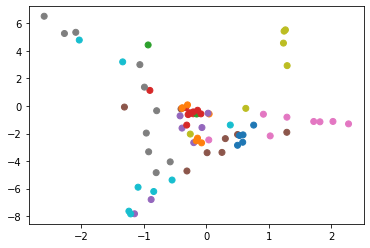

In [35]:
# 검증을 위한 시각화
#각 색이 각각 다른 숫자를 의미
plt.scatter(y[:,0], y[:,1], c=label.astype(int), cmap='tab10')

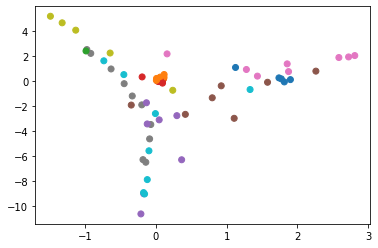

In [36]:
k_manhattan=get_neighbors(data, 5, distance='manhattan')
W=get_W(data, k_manhattan)
y=get_lower_y(data,2, W)
plt.scatter(y[:,0], y[:,1], c=label.astype(int), cmap='tab10')

# 다양한 Hyperparameter 비교 실험

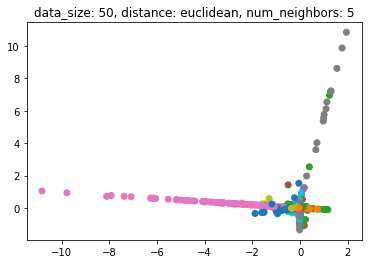

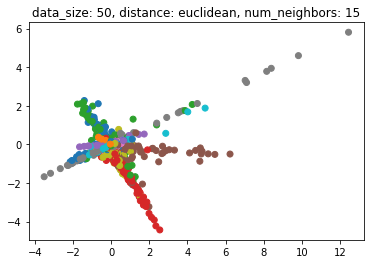

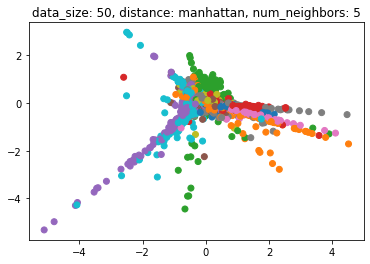

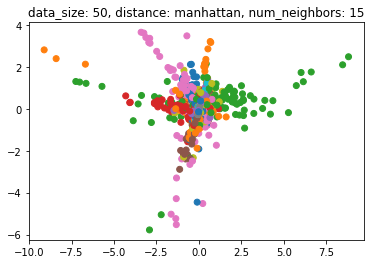

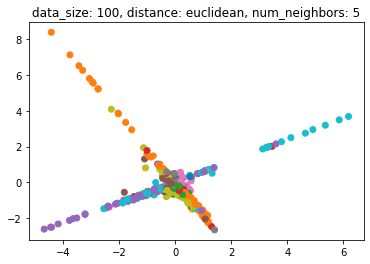

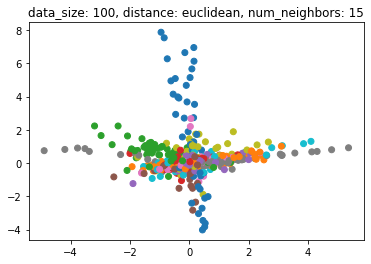

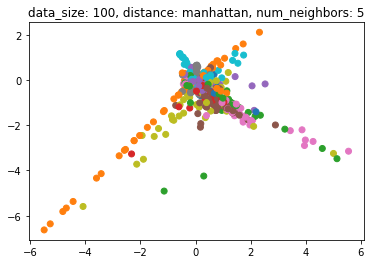

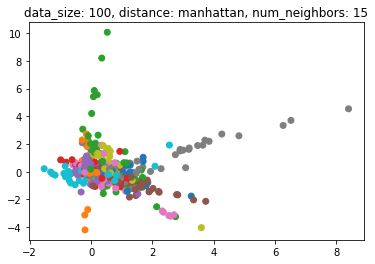

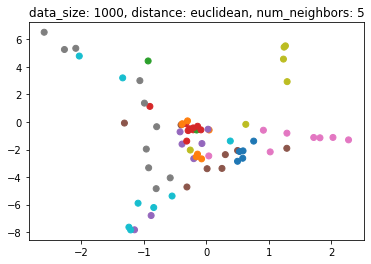

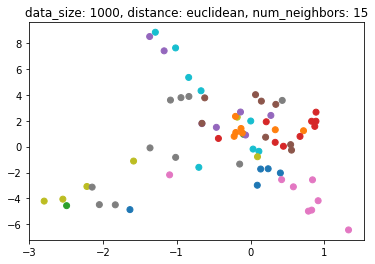

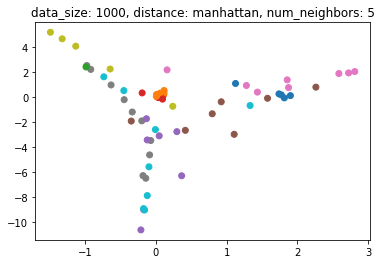

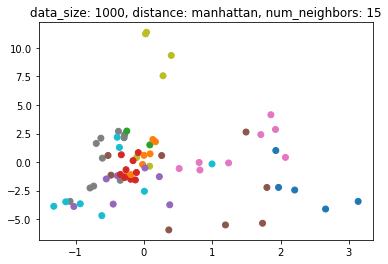

In [39]:
data_size = [50, 100, 1000] #각각 mnist에서 1/50, 1/100, 1/1000개의 데이터를 사용
distance=['euclidean', 'manhattan']
num_neighbors=[5, 15]

for i in data_size:
    data=MNIST[::i]
    label=MNIST_label[::i]
    for j in distance:
        for k in num_neighbors:
            k_neighbors=get_neighbors(data, k, distance=j)
            W=get_W(data, k_neighbors)
            y=get_lower_y(data,2, W)
            plt.scatter(y[:,0], y[:,1], c=label.astype(int), cmap='tab10')
            plt.title('data_size: 1/{}, distance: {}, num_neighbors: {}'.format(i,j,k))
            plt.show()
